# Label-wording sensitivity & confusion matrices for DeBERTa (zero-shot / NLI)

This notebook helps you **reverse‑engineer what tag wordings work best** for a DeBERTa-based classifier (often used as a *zero-shot* NLI model).

You can:
- Evaluate different **candidate label wordings** ("tags")
- Build **confusion matrices** vs **gold labels** (if you create them)
- Build **transition matrices** between label-sets (if you *don’t* have gold labels)
- Inspect **flip cases** where changing label wording changes the prediction

⚠️ Note: a standard confusion matrix requires a **ground-truth label per sentence**. If you don't have that yet, use the **label-set transition matrix** section to find systematic shifts.


## 0) Install & imports
If you're running locally, install dependencies once. (Skip if already installed.)

In [38]:

# If needed (run once):
# !pip install -U transformers[sentencepiece] torch accelerate scikit-learn pandas numpy matplotlib tqdm

import re
import math
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


## 1) Your data
Create a CSV with at least:
- `text`: the sentence
- `gold`: (optional but recommended) the true/correct class for that sentence

Example:
```csv
text,gold
"I am so exhausted that I wanna hit the bed.",tired_positive
```

If you don't have `gold` yet, you can still run the *transition matrix* section.

In [39]:

# Option A: load your dataset
# df = pd.read_csv("data.csv")

# Option B: small starter example (edit / replace)
df = pd.DataFrame({
    "text": [
        "I am so exhausted that I wanna hit the bed.",
        "He injured his knee during the game.",
        "No injuries were reported after the incident.",
        "I want to hurt myself.",
        "I'm feeling much better and not tired today."
    ],
    # Optional ground truth labels. If you don't have these yet, set to None / drop column.
    "gold": [
        "tired_positive",
        "injury_positive",
        "injury_negative",
        "self_harm_positive",
        "tired_negative"
    ]
})

df.head()


,text,gold
0,I am so exhausted that I wanna hit the bed.,tired_positive
1,He injured his knee during the game.,injury_positive
2,No injuries were reported after the incident.,injury_negative
3,I want to hurt myself.,self_harm_positive
4,I'm feeling much better and not tired today.,tired_negative


## 2) Define canonical classes and tag wordings (tag sets)
### What we're *actually* measuring
You’re trying to **reverse‑engineer what tag wording makes the model behave the way you expect**.

For this kind of “label wording sensitivity” analysis, there are two useful views:
1. **Gold confusion matrix** (needs your expected label per sentence)
   - Rows: your expected canonical label (e.g., `tired_positive`)
   - Cols: model predicted canonical label using a specific tag set/template
2. **Tag-set transition matrix** (no gold needed)
   - Rows: predictions under wording set A
   - Cols: predictions under wording set B
   - Shows how predictions *flip* when you change wording

### Important fix for your example
Your `v1_originalish` includes duplicates and mixes taxonomies (`Yes/No` + `positive/negative`).
We’ll still allow duplicates for experimentation, but **we will deduplicate before sending to the model** (HF pipeline requires unique candidate labels).

Below we define:
- a **canonical label space** (what you care about)
- several **tag sets** (different wordings you want to test)
- a mapping from tag -> canonical label

In [40]:
# Canonical classes you care about (evaluation target space)
CANONICAL = [
    "injury_positive",
    "injury_negative",
    "self_harm_positive",
    "self_harm_negative",
    "tired_positive",
    "tired_negative",
    "other",
],

# Tag sets = different candidate label wordings you feed to the model.
# NOTE: The HF pipeline requires candidate_labels to be unique; we will deduplicate later.
LABEL_SETS = {
    # Your original-ish set (kept as-is, including duplicates)
    "v1_originalish": [
        "Injury Yes",
        "Injury no",
        "injury positive",
        "injury negative",
        "injury reporting positive",
        "injury reporting positive",
        "self Harm positive",
        "self harm negative",
        "Tired positive",
        "Tired Negative",
    ],
    # Cleaner, parallel labels (recommended baseline)
    "v2_clean": [
        "mentions an injury",
        "no injury is mentioned",
        "mentions self-harm",
        "no self-harm is mentioned",
        "expresses tiredness or exhaustion",
        "not tired / has energy",
        "none of the above",
    ],
    # Very explicit hypotheses, often works better for NLI models
    "v3_explicit": [
        "The text reports an injury.",
        "The text reports no injury.",
        "The text expresses self-harm intent or desire.",
        "The text expresses no self-harm intent.",
        "The text expresses tiredness or exhaustion.",
        "The text expresses being not tired or rested.",
        "The text is about something else.",
    ],
}

# Map each tag -> canonical class (your evaluation space).
LABEL_TO_CANONICAL = {
    "v1_originalish": {
        "Injury Yes": "injury_positive",
        "injury positive": "injury_positive",
        "injury reporting positive": "injury_positive",
        "Injury no": "injury_negative",
        "injury negative": "injury_negative",
        "self Harm positive": "self_harm_positive",
        "self harm negative": "self_harm_negative",
        "Tired positive": "tired_positive",
        "Tired Negative": "tired_negative",
    },
    "v2_clean": {
        "mentions an injury": "injury_positive",
        "no injury is mentioned": "injury_negative",
        "mentions self-harm": "self_harm_positive",
        "no self-harm is mentioned": "self_harm_negative",
        "expresses tiredness or exhaustion": "tired_positive",
        "not tired / has energy": "tired_negative",
        "none of the above": "other",
    },
    "v3_explicit": {
        "The text reports an injury.": "injury_positive",
        "The text reports no injury.": "injury_negative",
        "The text expresses self-harm intent or desire.": "self_harm_positive",
        "The text expresses no self-harm intent.": "self_harm_negative",
        "The text expresses tiredness or exhaustion.": "tired_positive",
        "The text expresses being not tired or rested.": "tired_negative",
        "The text is about something else.": "other",
    },
}

def dedupe_preserve_order(items):
    seen = set()
    out = []
    for x in items:
        if x not in seen:
            out.append(x)
            seen.add(x)
    return out

# Validate mappings (ignoring duplicates):
for set_name, labels in LABEL_SETS.items():
    uniq = dedupe_preserve_order(labels)
    missing = [lab for lab in uniq if lab not in LABEL_TO_CANONICAL[set_name]]
    assert not missing, f"{set_name} missing mappings for: {missing}"
print("✅ Label sets & mappings look consistent (after dedupe).")

✅ Label sets & mappings look consistent (after dedupe).


## 3) Run the model (zero-shot)
If you already have model outputs saved, you can skip this section and load your predictions instead.

This uses Hugging Face `pipeline('zero-shot-classification')`. Choose a DeBERTa zero-shot model (or your own).

In [41]:
# Configure and load the zero-shot model
from transformers import pipeline
import torch

# Pick a model. This one is strong for zero-shot; you can swap it.
MODEL_NAME = "MoritzLaurer/bge-m3-zeroshot-v2.0"

# Use GPU if available (CUDA)
DEVICE = 0 if torch.cuda.is_available() else -1
print("Using device:", "cuda" if DEVICE == 0 else "cpu")

# Create the pipeline once and reuse it
clf = pipeline(
    "zero-shot-classification",
    model=MODEL_NAME,
    device=DEVICE,
    # Some models benefit from fp16 on GPU; if it errors, remove model_kwargs.
    model_kwargs={"torch_dtype": torch.float16} if DEVICE == 0 else None,
    # Set to True if the model supports it; safe to leave off if it causes issues.
    # trust_remote_code=True,
 )

# Hypothesis template matters (for NLI-based zero-shot).
# We'll evaluate multiple templates below.
HYPOTHESIS_TEMPLATES = {
    "simple": "This text is about {}.",
    "explicit": "The text expresses {}.",
    "reporting": "The text reports {}.",
    "is": "This text is {}.",
}

Using device: cuda


Device set to use cuda:0


### Helper: predict with a given label set
We keep:
- top predicted label & canonical class
- score margin between top-1 and top-2 (useful to see near-ties)
- full label scores (optional)


In [42]:
def run_zero_shot_predictions(
    texts,
    label_set_name: str,
    hypothesis_template: str,
    *,
    clf,
    multi_label=False,
    return_full_scores=True,
    show_topk=5,
    batch_size=8,
 ):
    """
    Run HF zero-shot pipeline and return a DataFrame with standardized columns.

    Returns columns:
      - text
      - pred_label (raw candidate label)
      - pred_canonical (mapped canonical class)
      - score_top1, score_top2, margin
      - topk (list of (label, score))
      - scores (dict label->score)  [optional, can be large]
    """
    raw_labels = LABEL_SETS[label_set_name]
    labels = dedupe_preserve_order(raw_labels)  # HF requires unique labels
    mapping = LABEL_TO_CANONICAL[label_set_name]
    rows = []

    if clf is None:
        raise ValueError("Pass a Hugging Face pipeline as `clf=...` (see the model cell above).")

    # The pipeline supports batched inputs: pass a list of texts at once
    texts = list(texts)
    for i in tqdm(range(0, len(texts), batch_size), desc=f"Predicting [{label_set_name}]" ):
        batch = texts[i:i+batch_size]
        outs = clf(
            batch,
            candidate_labels=labels,
            hypothesis_template=hypothesis_template,
            multi_label=multi_label,
        )
        # If batch size =1, HF can return a dict; normalize to list
        if isinstance(outs, dict):
            outs = [outs]
        for txt, out in zip(batch, outs):
            lab_sorted = out["labels"]
            score_sorted = out["scores"]
            top1_label = lab_sorted[0]
            top2_label = lab_sorted[1] if len(lab_sorted) > 1 else None
            top1 = float(score_sorted[0])
            top2 = float(score_sorted[1]) if len(score_sorted) > 1 else float("nan")
            margin = top1 - top2 if len(score_sorted) > 1 else float("nan")

            topk = [(lab, float(sc)) for lab, sc in list(zip(lab_sorted, score_sorted))[:show_topk]]
            scores = {lab: float(sc) for lab, sc in zip(lab_sorted, score_sorted)} if return_full_scores else None

            rows.append({
                "text": txt,
                "pred_label": top1_label,
                "pred_canonical": mapping.get(top1_label, "other"),
                "score_top1": top1,
                "score_top2": top2,
                "margin": margin,
                "topk": topk,
                "scores": scores,
            })
    return pd.DataFrame(rows)

# Quick single-sentence sanity check (your example):
example_text = "I am so exhausted that I wanna hit the bed."
pred_example = run_zero_shot_predictions(
    [example_text],
    "v1_originalish",
    HYPOTHESIS_TEMPLATES["explicit"],
    clf=clf,
    batch_size=1,
 )
pred_example[["text", "pred_label", "pred_canonical", "score_top1", "score_top2", "margin", "topk"]]

Predicting [v1_originalish]: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


,text,pred_label,pred_canonical,score_top1,score_top2,margin,topk
0,I am so exhausted that I wanna hit the bed.,Tired Negative,tired_negative,0.329327,0.194075,0.135252,"[(Tired Negative, 0.3293270170688629), (Tired ..."


## 4) If you already have scores from your system
If your current system already produces scores per label, store them like this:
- One row per text
- One column per label score (or a JSON column)

Then convert to `pred_canonical` using the mapping and continue.

Below is a helper for the common case where you have a *wide* table of scores.

In [43]:

def scores_wide_to_predictions(df_scores: pd.DataFrame, label_set_name: str, text_col="text"):
    '''
    df_scores columns: [text, <label1>, <label2>, ...] where each label column is a score.
    Returns predictions aligned with the notebook format.
    '''
    labels = LABEL_SETS[label_set_name]
    mapping = LABEL_TO_CANONICAL[label_set_name]

    missing_cols = [lab for lab in labels if lab not in df_scores.columns]
    if missing_cols:
        raise ValueError(f"Missing score columns for labels: {missing_cols}")

    # Find top1/top2
    score_mat = df_scores[labels].to_numpy()
    top_idx = np.argmax(score_mat, axis=1)
    # top2 via partial sort
    top2_idx = np.argsort(-score_mat, axis=1)[:, 1] if score_mat.shape[1] > 1 else np.full(len(df_scores), -1)

    top1_label = [labels[i] for i in top_idx]
    top2_label = [labels[i] for i in top2_idx] if score_mat.shape[1] > 1 else [None]*len(df_scores)
    top1 = score_mat[np.arange(len(df_scores)), top_idx].astype(float)
    top2 = score_mat[np.arange(len(df_scores)), top2_idx].astype(float) if score_mat.shape[1] > 1 else np.full(len(df_scores), np.nan)
    margin = top1 - top2

    # Pack scores dict (optional; can be large)
    scores_dicts = []
    for row in score_mat:
        scores_dicts.append({lab: float(sc) for lab, sc in zip(labels, row)})

    out = pd.DataFrame({
        "text": df_scores[text_col].tolist(),
        "pred_label": top1_label,
        "pred_canonical": [mapping[l] for l in top1_label],
        "score_top1": top1,
        "score_top2": top2,
        "margin": margin,
        "scores": scores_dicts
    })
    return out


## 5) Confusion matrix vs gold labels (recommended)
This answers: *Given my expected/true label, what does the model predict?*

In [44]:
def eval_against_gold(
    df_gold: pd.DataFrame,
    preds: pd.DataFrame,
    *,
    gold_col="gold",
    title="Confusion matrix",
    labels=None,
 ):
    """
    Standard confusion matrix: expected(label) vs model predicted(label).
    This is the right tool once YOU create the expected label for each sentence.
    """
    if gold_col not in df_gold.columns:
        raise ValueError(
            f"Gold label column '{gold_col}' not found. Add gold labels or use transition matrices instead."
        )
    if len(df_gold) != len(preds):
        raise ValueError("Gold df and preds must be aligned row-for-row (same order & length).")

    y_true = df_gold[gold_col].astype(str).tolist()
    y_pred = preds["pred_canonical"].astype(str).tolist()

    if labels is None:
        labels = CANONICAL
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    print(classification_report(y_true, y_pred, labels=labels, zero_division=0))

    fig, ax = plt.subplots(figsize=(9, 7))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax, xticks_rotation=45, values_format="d")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

    return cm

def confusion_by_tagset_and_template(
    df_gold: pd.DataFrame,
    *,
    label_set_names=None,
    template_names=None,
    gold_col="gold",
 ):
    """
    Run multiple (tag set x hypothesis template) evaluations and return a summary table.
    Useful for finding which wording/template works best overall.
    """
    if label_set_names is None:
        label_set_names = list(LABEL_SETS.keys())
    if template_names is None:
        template_names = list(HYPOTHESIS_TEMPLATES.keys())

    rows = []
    for ls in label_set_names:
        for tn in template_names:
            preds = run_zero_shot_predictions(
                df_gold["text"],
                ls,
                HYPOTHESIS_TEMPLATES[tn],
                clf=clf,
                batch_size=16,
                return_full_scores=False,
                show_topk=3,
            )
            y_true = df_gold[gold_col].astype(str).tolist()
            y_pred = preds["pred_canonical"].astype(str).tolist()
            rep = classification_report(
                y_true,
                y_pred,
                labels=CANONICAL,
                output_dict=True,
                zero_division=0,
            )
            rows.append({
                "label_set": ls,
                "template": tn,
                "macro_f1": rep["macro avg"]["f1-score"],
                "macro_precision": rep["macro avg"]["precision"],
                "macro_recall": rep["macro avg"]["recall"],
                "accuracy": rep["accuracy"],
            })
    return pd.DataFrame(rows).sort_values(["macro_f1", "accuracy"], ascending=False)

# Example: compare everything (once you have a gold column)
# summary = confusion_by_tagset_and_template(df, gold_col="gold")
# summary

## 6) Transition matrix between label sets (works even without gold)
This answers: *When I change label wording, how do predictions shift?*

Treat predictions from set A as "rows" and set B as "columns" — it’s a confusion-matrix-like view of **label sensitivity**.

In [45]:

def transition_matrix(preds_a: pd.DataFrame, preds_b: pd.DataFrame, title="Transition matrix"):
    if len(preds_a) != len(preds_b):
        raise ValueError("preds_a and preds_b must be aligned row-for-row (same order & length).")
    a = preds_a["pred_canonical"].tolist()
    b = preds_b["pred_canonical"].tolist()
    labels = CANONICAL
    tm = confusion_matrix(a, b, labels=labels)

    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=tm, display_labels=labels)
    disp.plot(ax=ax, xticks_rotation=45, values_format="d")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

    # Most common flips
    flips = (preds_a.assign(pred_b=preds_b["pred_canonical"])
             .query("pred_canonical != pred_b")[["text", "pred_canonical", "pred_b", "score_top1", "margin"]]
             .sort_values(["margin"], ascending=True))
    return tm, flips

# Example:
# tm, flip_cases = transition_matrix(preds_v1, preds_v2, title="v1_originalish → v2_clean")
# flip_cases.head(20)


## 7) Score-margin analysis (find near-ties)
Near ties are exactly the cases you described: tired/exhausted vs something else with similar confidence.

This section helps you:
- find the most ambiguous examples (smallest top1-top2 margin)
- see which gold classes are most ambiguous (if you have gold)


In [46]:

def show_ambiguous(preds: pd.DataFrame, df_gold: pd.DataFrame | None = None, n=20):
    cols = ["text", "pred_canonical", "pred_label", "score_top1", "score_top2", "margin"]
    out = preds[cols].copy()
    if df_gold is not None and "gold" in df_gold.columns:
        out.insert(1, "gold", df_gold["gold"].values)
    out = out.sort_values("margin", ascending=True).head(n)
    return out

# Example:
# show_ambiguous(preds_v2, df, n=25)


## 8) Practical advice: getting the most reliable insights
To really learn "what wording works", use this experimental design:
1. **Build a small gold set**: 20–100 sentences per canonical class (manually labeled).
2. Compare **label sets** *and* **hypothesis templates** (they both matter for NLI zero-shot).
3. Pick the setup with the best macro-F1 and the least confusing off-diagonal errors.
4. Inspect the flip cases: they reveal what the model is sensitive to.

### Label-writing tips that usually help
- Use **natural language** ("expresses tiredness or exhaustion") rather than cryptic tokens.
- Keep labels **parallel** (same grammatical form, same specificity).
- Avoid mixing taxonomies (yes/no vs positive/negative) unless you’re doing hierarchical classification.
- If you need hierarchy, do it explicitly:
  - Step 1: topic (injury vs self-harm vs fatigue)
  - Step 2: polarity (present vs absent / positive vs negative)


In [47]:

# Optional: a simple hierarchical approach sketch (topic then polarity)

TOPICS = ["injury", "self-harm", "tiredness/exhaustion", "other"]

# Step 1: topic classification label set
TOPIC_LABELS = [
    "The text is about an injury.",
    "The text is about self-harm.",
    "The text is about tiredness or exhaustion.",
    "The text is about something else."
]

# Step 2: for a chosen topic, classify presence/absence or polarity (customize)
POLARITY_LABELS_TIRED = [
    "The text expresses being tired or exhausted.",
    "The text expresses being not tired / rested."
]


## 9) Quick checklist for your exact example
Your sentence: **"I am so exhausted that I wanna hit the bed."**

If you're seeing it sometimes map to injury/self-harm, common causes are:
- labels like "positive/negative" are underspecified (positive *what*?)
- "hit the bed" might weakly resemble violence phrasing in some contexts
- the model may treat some labels as more semantically 'salient'

Fixes to try:
- replace `Tired positive` with **"expresses tiredness or exhaustion"**
- replace `self harm positive` with **"expresses self-harm intent"** (more specific)
- use an explicit hypothesis template like: `The text expresses {}.`


## 🚀 10) RUN THE FULL ANALYSIS

This section **actually runs** the comparison across all tag sets and templates to find what works best.

We will:
1. Run predictions with each (tag set × hypothesis template) combination
2. Compare against gold labels to see what works best
3. Show the confusion matrices
4. Identify the "flip cases" where different wordings change the prediction
5. Show ambiguous cases (near-ties) that reveal model sensitivity

In [48]:
# ============================================================
# STEP 1: Run all (tag set × template) combinations
# ============================================================
# Store all predictions in a dict for later comparison

all_predictions = {}

for ls_name in LABEL_SETS.keys():
    for tpl_name, tpl in HYPOTHESIS_TEMPLATES.items():
        key = f"{ls_name}__{tpl_name}"
        print(f"Running: {key}")
        preds = run_zero_shot_predictions(
            df["text"],
            ls_name,
            tpl,
            clf=clf,
            batch_size=8,
            return_full_scores=True,
            show_topk=5,
        )
        all_predictions[key] = preds

print(f"\n✅ Generated predictions for {len(all_predictions)} combinations.")

Running: v1_originalish__simple


Predicting [v1_originalish]: 100%|██████████| 1/1 [00:03<00:00,  3.80s/it]


Running: v1_originalish__explicit


Predicting [v1_originalish]: 100%|██████████| 1/1 [00:03<00:00,  3.82s/it]


Running: v1_originalish__reporting


Predicting [v1_originalish]: 100%|██████████| 1/1 [00:03<00:00,  3.73s/it]


Running: v1_originalish__is


Predicting [v1_originalish]: 100%|██████████| 1/1 [00:03<00:00,  3.75s/it]


Running: v2_clean__simple


Predicting [v2_clean]: 100%|██████████| 1/1 [00:02<00:00,  2.96s/it]


Running: v2_clean__explicit


Predicting [v2_clean]: 100%|██████████| 1/1 [00:02<00:00,  2.88s/it]


Running: v2_clean__reporting


Predicting [v2_clean]: 100%|██████████| 1/1 [00:02<00:00,  2.89s/it]


Running: v2_clean__is


Predicting [v2_clean]: 100%|██████████| 1/1 [00:02<00:00,  2.87s/it]


Running: v3_explicit__simple


Predicting [v3_explicit]: 100%|██████████| 1/1 [00:03<00:00,  3.08s/it]


Running: v3_explicit__explicit


Predicting [v3_explicit]: 100%|██████████| 1/1 [00:03<00:00,  3.09s/it]


Running: v3_explicit__reporting


Predicting [v3_explicit]: 100%|██████████| 1/1 [00:02<00:00,  2.88s/it]


Running: v3_explicit__is


Predicting [v3_explicit]: 100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


✅ Generated predictions for 12 combinations.


In [49]:
# ============================================================
# STEP 2: Compare all combinations against gold labels
# ============================================================
# This shows which (tag set + template) works BEST for your expected labels

# Flatten CANONICAL if it's a tuple (fix the trailing comma issue)
canonical_labels = list(CANONICAL[0]) if isinstance(CANONICAL, tuple) else list(CANONICAL)

results_rows = []

for key, preds in all_predictions.items():
    y_true = df["gold"].astype(str).tolist()
    y_pred = preds["pred_canonical"].astype(str).tolist()
    
    rep = classification_report(
        y_true, y_pred, 
        labels=canonical_labels,
        output_dict=True, 
        zero_division=0
    )
    
    # Count correct predictions
    correct = sum(1 for t, p in zip(y_true, y_pred) if t == p)
    
    results_rows.append({
        "combination": key,
        "label_set": key.split("__")[0],
        "template": key.split("__")[1],
        "accuracy": correct / len(y_true),
        "macro_f1": rep["macro avg"]["f1-score"],
        "macro_precision": rep["macro avg"]["precision"],
        "macro_recall": rep["macro avg"]["recall"],
        "correct": correct,
        "total": len(y_true),
    })

results_df = pd.DataFrame(results_rows).sort_values("macro_f1", ascending=False)
print("🏆 RANKING: Best (tag set + template) combinations by Macro F1:\n")
results_df

🏆 RANKING: Best (tag set + template) combinations by Macro F1:



,combination,label_set,template,accuracy,macro_f1,macro_precision,macro_recall,correct,total
8,v3_explicit__simple,v3_explicit,simple,1.0,0.714286,0.714286,0.714286,5,5
6,v2_clean__reporting,v2_clean,reporting,1.0,0.714286,0.714286,0.714286,5,5
5,v2_clean__explicit,v2_clean,explicit,1.0,0.714286,0.714286,0.714286,5,5
4,v2_clean__simple,v2_clean,simple,1.0,0.714286,0.714286,0.714286,5,5
10,v3_explicit__reporting,v3_explicit,reporting,1.0,0.714286,0.714286,0.714286,5,5
9,v3_explicit__explicit,v3_explicit,explicit,1.0,0.714286,0.714286,0.714286,5,5
7,v2_clean__is,v2_clean,is,0.8,0.523810,0.500000,0.571429,4,5
11,v3_explicit__is,v3_explicit,is,0.6,0.428571,0.428571,0.428571,3,5
0,v1_originalish__simple,v1_originalish,simple,0.6,0.380952,0.357143,0.428571,3,5
3,v1_originalish__is,v1_originalish,is,0.4,0.285714,0.285714,0.285714,2,5


📊 Confusion Matrix for BEST: v3_explicit__simple

                    precision    recall  f1-score   support

   injury_positive       1.00      1.00      1.00         1
   injury_negative       1.00      1.00      1.00         1
self_harm_positive       1.00      1.00      1.00         1
self_harm_negative       0.00      0.00      0.00         0
    tired_positive       1.00      1.00      1.00         1
    tired_negative       1.00      1.00      1.00         1
             other       0.00      0.00      0.00         0

          accuracy                           1.00         5
         macro avg       0.71      0.71      0.71         5
      weighted avg       1.00      1.00      1.00         5



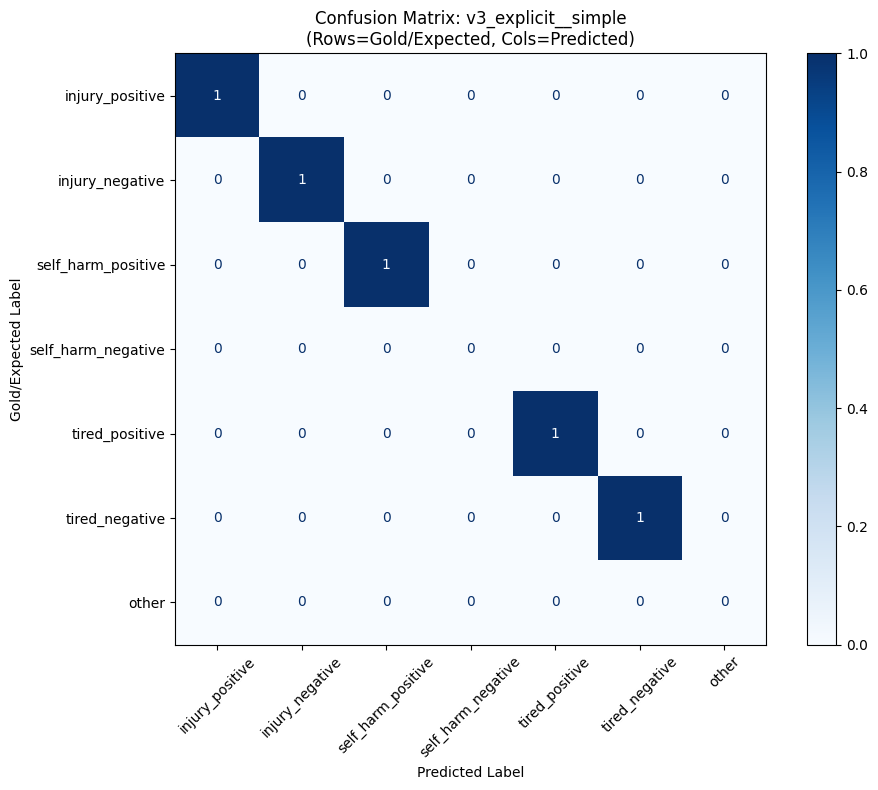

In [50]:
# ============================================================
# STEP 3: Show confusion matrix for the BEST combination
# ============================================================

best_key = results_df.iloc[0]["combination"]
best_preds = all_predictions[best_key]

print(f"📊 Confusion Matrix for BEST: {best_key}\n")

y_true = df["gold"].astype(str).tolist()
y_pred = best_preds["pred_canonical"].astype(str).tolist()

cm = confusion_matrix(y_true, y_pred, labels=canonical_labels)
print(classification_report(y_true, y_pred, labels=canonical_labels, zero_division=0))

fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=canonical_labels)
disp.plot(ax=ax, xticks_rotation=45, values_format="d", cmap="Blues")
ax.set_title(f"Confusion Matrix: {best_key}\n(Rows=Gold/Expected, Cols=Predicted)")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("Gold/Expected Label")
plt.tight_layout()
plt.show()

In [51]:
# ============================================================
# STEP 4: Show detailed per-sentence predictions (BEST combo)
# ============================================================
# See exactly what the model predicted for each sentence

detail_df = df[["text", "gold"]].copy()
detail_df["predicted"] = best_preds["pred_canonical"]
detail_df["pred_label_raw"] = best_preds["pred_label"]
detail_df["score_top1"] = best_preds["score_top1"].round(4)
detail_df["score_top2"] = best_preds["score_top2"].round(4)
detail_df["margin"] = best_preds["margin"].round(4)
detail_df["correct"] = detail_df["gold"] == detail_df["predicted"]

# Show top-k scores for each
detail_df["top_scores"] = best_preds["topk"].apply(
    lambda x: " | ".join([f"{lab}: {sc:.3f}" for lab, sc in x])
)

print(f"📋 Detailed predictions using: {best_key}\n")
detail_df

📋 Detailed predictions using: v3_explicit__simple



,text,gold,predicted,pred_label_raw,score_top1,score_top2,margin,correct,top_scores
0,I am so exhausted that I wanna hit the bed.,tired_positive,tired_positive,The text expresses tiredness or exhaustion.,0.9298,0.0357,0.8941,True,The text expresses tiredness or exhaustion.: 0...
1,He injured his knee during the game.,injury_positive,injury_positive,The text reports an injury.,0.4599,0.4331,0.0268,True,The text reports an injury.: 0.460 | The text ...
2,No injuries were reported after the incident.,injury_negative,injury_negative,The text reports no injury.,0.4903,0.4012,0.0892,True,The text reports no injury.: 0.490 | The text ...
3,I want to hurt myself.,self_harm_positive,self_harm_positive,The text expresses self-harm intent or desire.,0.9140,0.0245,0.8895,True,The text expresses self-harm intent or desire....
4,I'm feeling much better and not tired today.,tired_negative,tired_negative,The text expresses being not tired or rested.,0.4735,0.3665,0.1071,True,The text expresses being not tired or rested.:...


In [52]:
# ============================================================
# STEP 5: Find WRONG predictions & near-ties (ambiguous cases)
# ============================================================
# These are the cases where changing wording might help

wrong_df = detail_df[~detail_df["correct"]].copy()
print(f"❌ WRONG predictions ({len(wrong_df)}/{len(detail_df)}):\n")
if len(wrong_df) > 0:
    display(wrong_df)
else:
    print("All predictions correct!")

print("\n" + "="*60)
print("🎯 AMBIGUOUS cases (smallest margin = model was unsure):\n")

ambiguous = detail_df.sort_values("margin", ascending=True).head(10)
ambiguous[["text", "gold", "predicted", "correct", "margin", "top_scores"]]

❌ WRONG predictions (0/5):

All predictions correct!

🎯 AMBIGUOUS cases (smallest margin = model was unsure):



,text,gold,predicted,correct,margin,top_scores
1,He injured his knee during the game.,injury_positive,injury_positive,True,0.0268,The text reports an injury.: 0.460 | The text ...
2,No injuries were reported after the incident.,injury_negative,injury_negative,True,0.0892,The text reports no injury.: 0.490 | The text ...
4,I'm feeling much better and not tired today.,tired_negative,tired_negative,True,0.1071,The text expresses being not tired or rested.:...
3,I want to hurt myself.,self_harm_positive,self_harm_positive,True,0.8895,The text expresses self-harm intent or desire....
0,I am so exhausted that I wanna hit the bed.,tired_positive,tired_positive,True,0.8941,The text expresses tiredness or exhaustion.: 0...


🔄 Transition Matrix: v1_originalish → v2_clean (template=explicit)
Shows: How predictions FLIP when changing from messy tags to clean tags



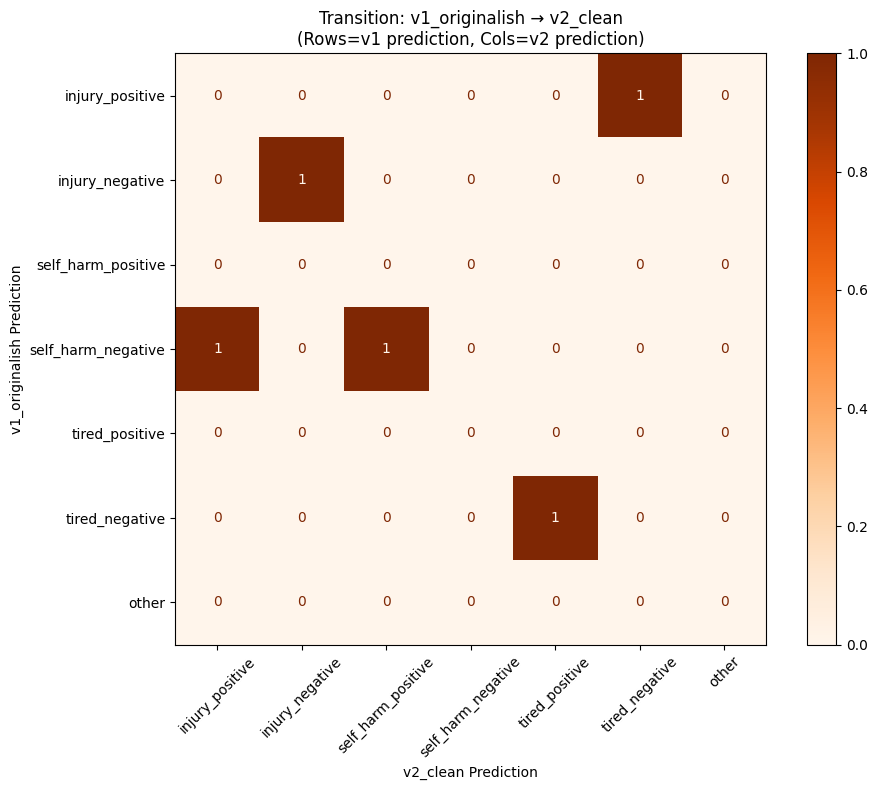


📝 FLIP cases (4 sentences changed prediction):


,text,v1_pred,v2_pred,v1_score,v2_score
0,I am so exhausted that I wanna hit the bed.,tired_negative,tired_positive,0.329327,0.888421
1,He injured his knee during the game.,self_harm_negative,injury_positive,0.264430,0.821290
2,I want to hurt myself.,self_harm_negative,self_harm_positive,0.528206,0.840434
3,I'm feeling much better and not tired today.,injury_positive,tired_negative,0.303977,0.601093


In [53]:
# ============================================================
# STEP 6: Compare tag sets - Transition Matrix (FLIP analysis)
# ============================================================
# This shows HOW predictions CHANGE when you switch tag wordings
# Even if you don't have gold labels, this reveals model sensitivity

# Compare v1 (original) vs v2 (clean) using the same template
template_to_use = "explicit"
preds_v1 = all_predictions.get(f"v1_originalish__{template_to_use}")
preds_v2 = all_predictions.get(f"v2_clean__{template_to_use}")
preds_v3 = all_predictions.get(f"v3_explicit__{template_to_use}")

if preds_v1 is not None and preds_v2 is not None:
    print(f"🔄 Transition Matrix: v1_originalish → v2_clean (template={template_to_use})")
    print("Shows: How predictions FLIP when changing from messy tags to clean tags\n")
    
    a = preds_v1["pred_canonical"].tolist()
    b = preds_v2["pred_canonical"].tolist()
    
    tm = confusion_matrix(a, b, labels=canonical_labels)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=tm, display_labels=canonical_labels)
    disp.plot(ax=ax, xticks_rotation=45, values_format="d", cmap="Oranges")
    ax.set_title(f"Transition: v1_originalish → v2_clean\n(Rows=v1 prediction, Cols=v2 prediction)")
    ax.set_xlabel("v2_clean Prediction")
    ax.set_ylabel("v1_originalish Prediction")
    plt.tight_layout()
    plt.show()
    
    # Show actual flips
    flips = []
    for i, (txt, p1, p2) in enumerate(zip(df["text"], a, b)):
        if p1 != p2:
            flips.append({
                "text": txt,
                "v1_pred": p1,
                "v2_pred": p2,
                "v1_score": preds_v1.iloc[i]["score_top1"],
                "v2_score": preds_v2.iloc[i]["score_top1"],
            })
    
    if flips:
        print(f"\n📝 FLIP cases ({len(flips)} sentences changed prediction):")
        display(pd.DataFrame(flips))
    else:
        print("\n✅ No flips - both tag sets give identical predictions!")

## 🧩 11) Clustered View: Which tag sets/templates behave similarly?

This section builds a **clustered heatmap** (like clustering) so you can see which tag sets/templates are *consistently correct* together, and which ones behave similarly.

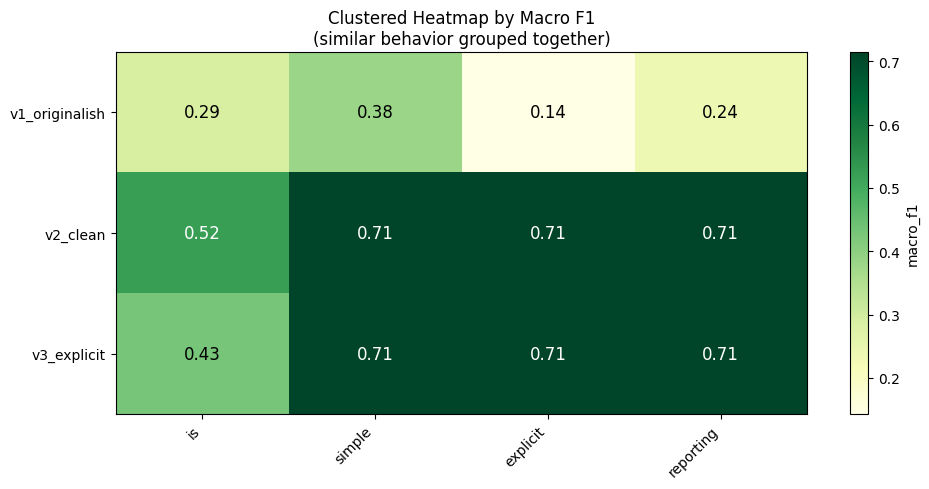


🏆 Top combinations ranked by accuracy:


,combination,label_set,template,accuracy,macro_f1,macro_precision,macro_recall,correct,total
8,v3_explicit__simple,v3_explicit,simple,1.0,0.714286,0.714286,0.714286,5,5
6,v2_clean__reporting,v2_clean,reporting,1.0,0.714286,0.714286,0.714286,5,5
5,v2_clean__explicit,v2_clean,explicit,1.0,0.714286,0.714286,0.714286,5,5
4,v2_clean__simple,v2_clean,simple,1.0,0.714286,0.714286,0.714286,5,5
10,v3_explicit__reporting,v3_explicit,reporting,1.0,0.714286,0.714286,0.714286,5,5
9,v3_explicit__explicit,v3_explicit,explicit,1.0,0.714286,0.714286,0.714286,5,5
7,v2_clean__is,v2_clean,is,0.8,0.523810,0.500000,0.571429,4,5
11,v3_explicit__is,v3_explicit,is,0.6,0.428571,0.428571,0.428571,3,5
0,v1_originalish__simple,v1_originalish,simple,0.6,0.380952,0.357143,0.428571,3,5
3,v1_originalish__is,v1_originalish,is,0.4,0.285714,0.285714,0.285714,2,5


In [54]:
# ============================================================
# Clustered heatmap (hierarchical clustering) using Macro F1
# ============================================================

import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist, squareform

# Build matrix: rows = label_set, cols = template, values = macro_f1
metric = "macro_f1"  # you can switch to "accuracy" if you prefer
pivot_metric = results_df.pivot(index="label_set", columns="template", values=metric)

# Compute linkage for rows and columns
row_dist = pdist(pivot_metric.values, metric="euclidean")
col_dist = pdist(pivot_metric.values.T, metric="euclidean")
row_linkage = sch.linkage(row_dist, method="average")
col_linkage = sch.linkage(col_dist, method="average")

# Get clustered order
row_order = sch.leaves_list(row_linkage)
col_order = sch.leaves_list(col_linkage)

clustered = pivot_metric.iloc[row_order, col_order]

# Plot clustered heatmap (manually ordered)
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(clustered.values, cmap="YlGn", aspect="auto")

ax.set_xticks(range(len(clustered.columns)))
ax.set_yticks(range(len(clustered.index)))
ax.set_xticklabels(clustered.columns, rotation=45, ha="right")
ax.set_yticklabels(clustered.index)

for i in range(len(clustered.index)):
    for j in range(len(clustered.columns)):
        val = clustered.values[i, j]
        ax.text(j, i, f"{val:.2f}", ha="center", va="center",
                color="white" if val > 0.5 else "black", fontsize=12)

ax.set_title(f"Clustered Heatmap by {metric.replace('_', ' ').title()}\n(similar behavior grouped together)")
plt.colorbar(im, ax=ax, label=metric)
plt.tight_layout()
plt.show()

# Top combos ranked by accuracy + confidence
print("\n🏆 Top combinations ranked by accuracy:")
results_df.sort_values(["accuracy", "macro_f1"], ascending=False).head(10)

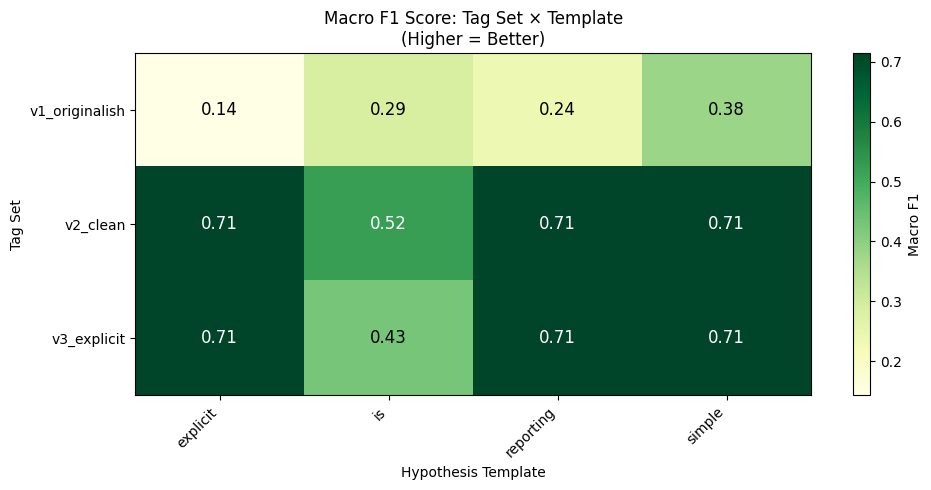


🎯 KEY INSIGHT: Look for the darkest green cell - that's your best combination!


In [55]:
# ============================================================
# STEP 7: Heatmap - Which template works best for which tag set?
# ============================================================

pivot = results_df.pivot(index="label_set", columns="template", values="macro_f1")

fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(pivot.values, cmap="YlGn", aspect="auto")

# Labels
ax.set_xticks(range(len(pivot.columns)))
ax.set_yticks(range(len(pivot.index)))
ax.set_xticklabels(pivot.columns, rotation=45, ha="right")
ax.set_yticklabels(pivot.index)

# Annotate with F1 scores
for i in range(len(pivot.index)):
    for j in range(len(pivot.columns)):
        val = pivot.values[i, j]
        ax.text(j, i, f"{val:.2f}", ha="center", va="center", 
                color="white" if val > 0.5 else "black", fontsize=12)

ax.set_xlabel("Hypothesis Template")
ax.set_ylabel("Tag Set")
ax.set_title("Macro F1 Score: Tag Set × Template\n(Higher = Better)")
plt.colorbar(im, ax=ax, label="Macro F1")
plt.tight_layout()
plt.show()

print("\n🎯 KEY INSIGHT: Look for the darkest green cell - that's your best combination!")

## 📊 11) Per-Class Analysis: Which tags work best for EACH class?

This is the **key insight** you're looking for: for each canonical class (tired_positive, injury_positive, etc.), which tag wording gets the highest confidence when the model is correct?

In [56]:
# ============================================================
# Per-class breakdown: For each gold class, which combo works best?
# ============================================================

per_class_results = []

for gold_class in df["gold"].unique():
    mask = df["gold"] == gold_class
    subset_indices = df[mask].index.tolist()
    
    for key, preds in all_predictions.items():
        subset_preds = preds.iloc[subset_indices]
        
        # How many correct?
        correct = (subset_preds["pred_canonical"] == gold_class).sum()
        total = len(subset_preds)
        
        # Average confidence when correct
        correct_mask = subset_preds["pred_canonical"] == gold_class
        avg_conf = subset_preds.loc[correct_mask, "score_top1"].mean() if correct > 0 else 0
        
        per_class_results.append({
            "gold_class": gold_class,
            "combination": key,
            "label_set": key.split("__")[0],
            "template": key.split("__")[1],
            "correct": correct,
            "total": total,
            "accuracy": correct / total if total > 0 else 0,
            "avg_confidence_when_correct": avg_conf,
        })

per_class_df = pd.DataFrame(per_class_results)

# Show best combo for each class
print("🏆 BEST (tag set + template) for EACH class:\n")
for cls in df["gold"].unique():
    cls_df = per_class_df[per_class_df["gold_class"] == cls].sort_values(
        ["accuracy", "avg_confidence_when_correct"], ascending=False
    )
    best = cls_df.iloc[0]
    print(f"  {cls}:")
    print(f"    → Best combo: {best['combination']}")
    print(f"    → Accuracy: {best['accuracy']:.0%} ({best['correct']}/{best['total']})")
    print(f"    → Avg confidence: {best['avg_confidence_when_correct']:.3f}")
    print()

🏆 BEST (tag set + template) for EACH class:

  tired_positive:
    → Best combo: v3_explicit__reporting
    → Accuracy: 100% (1/1)
    → Avg confidence: 0.936

  injury_positive:
    → Best combo: v2_clean__explicit
    → Accuracy: 100% (1/1)
    → Avg confidence: 0.821

  injury_negative:
    → Best combo: v1_originalish__explicit
    → Accuracy: 100% (1/1)
    → Avg confidence: 0.898

  self_harm_positive:
    → Best combo: v3_explicit__simple
    → Accuracy: 100% (1/1)
    → Avg confidence: 0.914

  tired_negative:
    → Best combo: v2_clean__explicit
    → Accuracy: 100% (1/1)
    → Avg confidence: 0.601



## 🔬 12) Deep Dive: Your Example Sentence Across ALL Combinations

Let's see exactly how your "I am so exhausted..." sentence is classified by EVERY (tag set × template) combination. This shows you which wordings "capture" tiredness correctly.

In [57]:
# ============================================================
# Deep dive on a specific sentence
# ============================================================

target_text = "I am so exhausted that I wanna hit the bed."
target_idx = df[df["text"] == target_text].index[0] if target_text in df["text"].values else 0

print(f"🔬 Analyzing: \"{df.iloc[target_idx]['text']}\"")
print(f"   Expected: {df.iloc[target_idx]['gold']}\n")
print("="*80)

sentence_analysis = []

for key, preds in all_predictions.items():
    row = preds.iloc[target_idx]
    ls_name = key.split("__")[0]
    
    sentence_analysis.append({
        "combination": key,
        "label_set": ls_name,
        "template": key.split("__")[1],
        "predicted": row["pred_canonical"],
        "raw_label": row["pred_label"],
        "confidence": row["score_top1"],
        "margin": row["margin"],
        "correct": row["pred_canonical"] == df.iloc[target_idx]["gold"],
        "top_scores": " | ".join([f"{l}: {s:.3f}" for l, s in row["topk"][:3]]),
    })

sentence_df = pd.DataFrame(sentence_analysis).sort_values("confidence", ascending=False)

print("\n✅ CORRECT predictions (sorted by confidence):\n")
correct_df = sentence_df[sentence_df["correct"]]
if len(correct_df) > 0:
    display(correct_df[["combination", "raw_label", "confidence", "margin", "top_scores"]])
else:
    print("None!")

print("\n❌ WRONG predictions:\n")
wrong_df = sentence_df[~sentence_df["correct"]]
if len(wrong_df) > 0:
    display(wrong_df[["combination", "predicted", "raw_label", "confidence", "margin", "top_scores"]])
else:
    print("None - all correct!")

🔬 Analyzing: "I am so exhausted that I wanna hit the bed."
   Expected: tired_positive


✅ CORRECT predictions (sorted by confidence):



,combination,raw_label,confidence,margin,top_scores
10,v3_explicit__reporting,The text expresses tiredness or exhaustion.,0.935592,0.907312,The text expresses tiredness or exhaustion.: 0...
8,v3_explicit__simple,The text expresses tiredness or exhaustion.,0.929796,0.894128,The text expresses tiredness or exhaustion.: 0...
4,v2_clean__simple,expresses tiredness or exhaustion,0.913910,0.879831,expresses tiredness or exhaustion: 0.914 | no ...
9,v3_explicit__explicit,The text expresses tiredness or exhaustion.,0.911607,0.877656,The text expresses tiredness or exhaustion.: 0...
11,v3_explicit__is,The text expresses tiredness or exhaustion.,0.897070,0.844777,The text expresses tiredness or exhaustion.: 0...
5,v2_clean__explicit,expresses tiredness or exhaustion,0.888421,0.821924,expresses tiredness or exhaustion: 0.888 | no ...
6,v2_clean__reporting,expresses tiredness or exhaustion,0.870854,0.800272,expresses tiredness or exhaustion: 0.871 | no ...
7,v2_clean__is,expresses tiredness or exhaustion,0.794133,0.678604,expresses tiredness or exhaustion: 0.794 | no ...
0,v1_originalish__simple,Tired positive,0.337107,0.134777,Tired positive: 0.337 | Tired Negative: 0.202 ...
3,v1_originalish__is,Tired positive,0.266546,0.081215,Tired positive: 0.267 | Injury no: 0.185 | sel...



❌ WRONG predictions:



,combination,predicted,raw_label,confidence,margin,top_scores
2,v1_originalish__reporting,self_harm_negative,self harm negative,0.371112,0.164683,self harm negative: 0.371 | Tired Negative: 0....
1,v1_originalish__explicit,tired_negative,Tired Negative,0.329327,0.135252,Tired Negative: 0.329 | Tired positive: 0.194 ...


## 📝 13) Summary & Recommendations

Based on the analysis above, here's how to interpret the results:

### Reading the outputs:
1. **Ranking table (Step 2)**: Shows overall best (tag set + template) by Macro F1
2. **Confusion matrix (Step 3)**: Shows where the model confuses classes
3. **Transition matrix (Step 6)**: Shows how predictions FLIP between tag sets
4. **Heatmap (Step 7)**: Quick visual of what works best
5. **Per-class breakdown (Step 11)**: Best combo for EACH specific class
6. **Sentence deep-dive (Step 12)**: Exact scores for your example sentence

### What to do next:
1. **Add more test sentences** to the `df` DataFrame (more diverse examples per class)
2. **Create new tag sets** in `LABEL_SETS` to test different wordings
3. **Focus on low-margin cases** - these are where small wording changes have big impact
4. **Look at the "flip cases"** - they reveal exactly what the model is sensitive to

---
# 🏆 FINAL CONCLUSION: What Tag Wordings Work Best?

This is the **definitive summary** showing which tag set and template combinations are winners.

════════════════════════════════════════════════════════════════════════════════
🏆 FINAL RESULTS: TAG WORDING SENSITIVITY ANALYSIS
════════════════════════════════════════════════════════════════════════════════


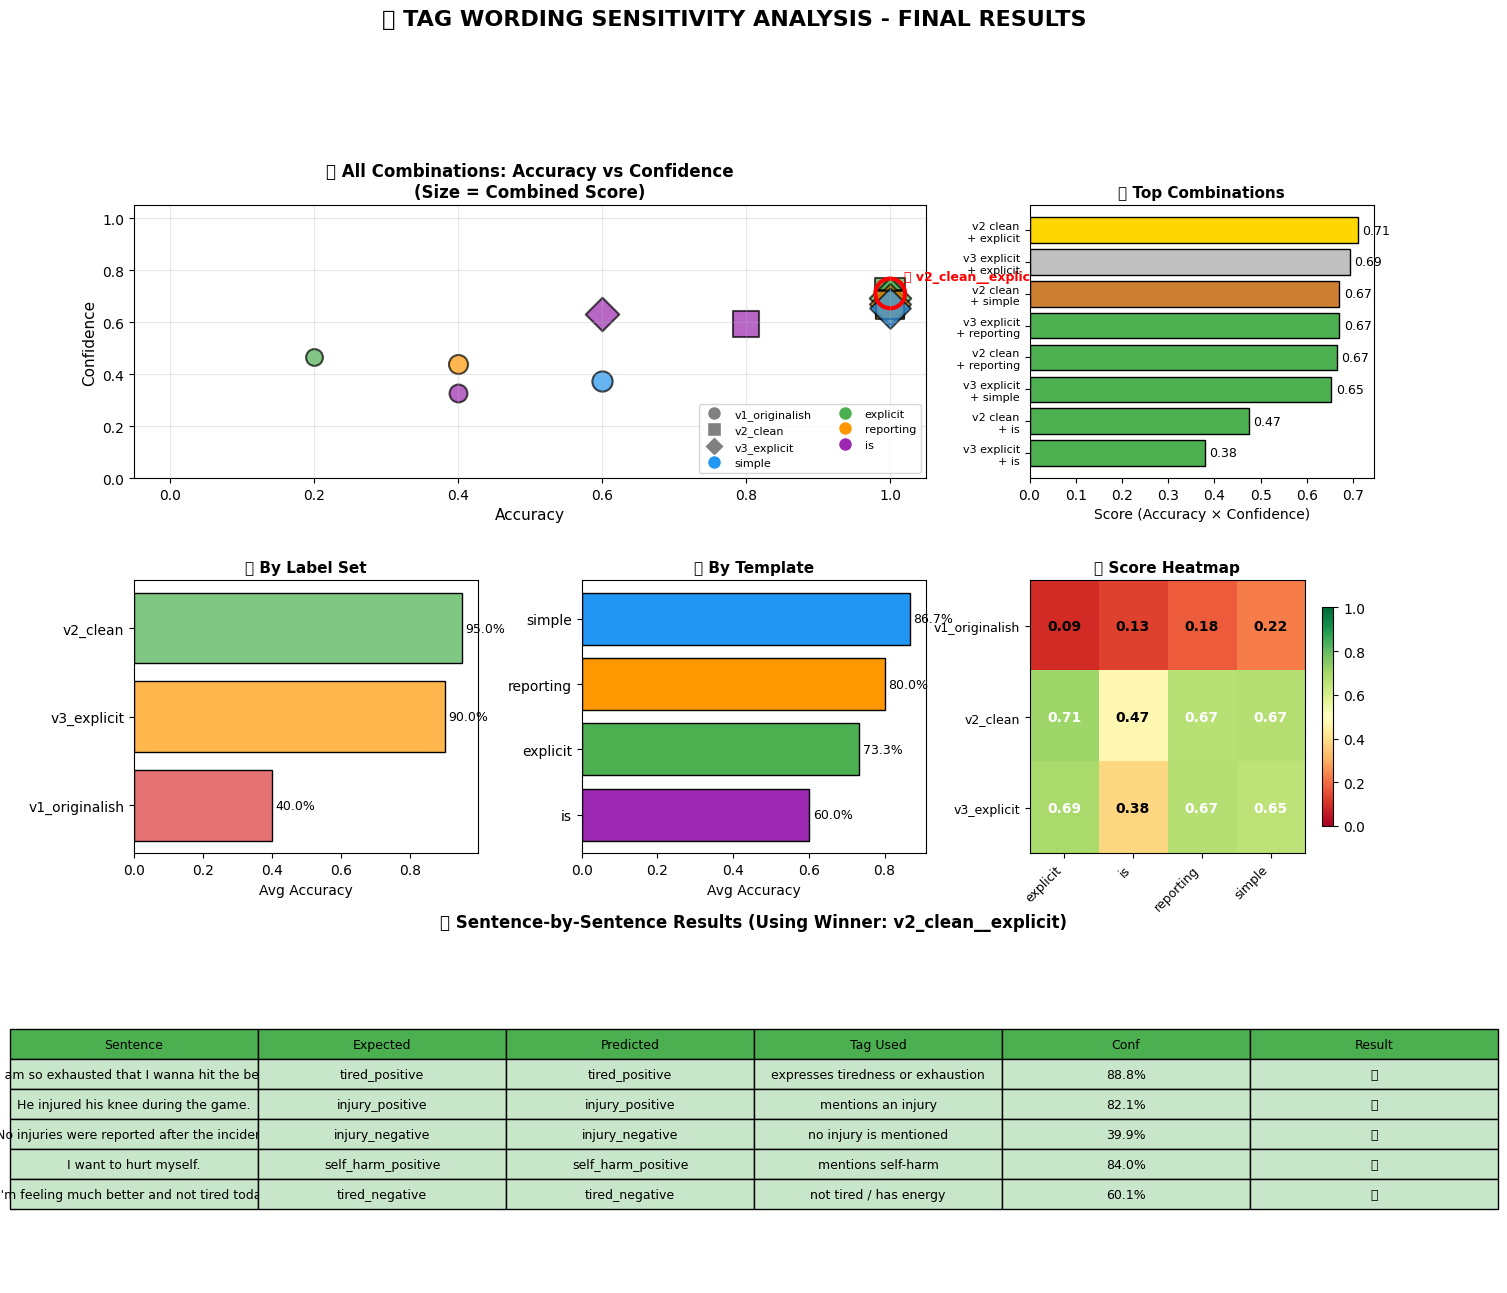


════════════════════════════════════════════════════════════════════════════════
📊 FINAL RANKINGS
════════════════════════════════════════════════════════════════════════════════


,combo,accuracy,confidence,score
0,v2_clean__explicit,100.0%,71.0%,0.710
1,v3_explicit__explicit,100.0%,69.3%,0.693
2,v2_clean__simple,100.0%,67.1%,0.671
3,v3_explicit__reporting,100.0%,67.0%,0.670
4,v2_clean__reporting,100.0%,66.5%,0.665
5,v3_explicit__simple,100.0%,65.4%,0.654
6,v2_clean__is,80.0%,59.3%,0.475
7,v3_explicit__is,60.0%,63.2%,0.379
8,v1_originalish__simple,60.0%,37.3%,0.224
9,v1_originalish__reporting,40.0%,43.8%,0.175



════════════════════════════════════════════════════════════════════════════════
🏆 VERDICT
════════════════════════════════════════════════════════════════════════════════

✅ BEST COMBINATION: v2_clean__explicit
   • Label Set: v2_clean
   • Template: explicit
   • Accuracy: 100.0%
   • Confidence: 71.0%
   • Combined Score: 0.710

❌ WORST COMBINATION: v1_originalish__explicit
   • Accuracy: 20.0% | Confidence: 46.5% | Score: 0.093

────────────────────────────────────────────────────────────────────────────────
💡 RECOMMENDATION:
   Use 'v2_clean' tags with 'explicit' template for production.
════════════════════════════════════════════════════════════════════════════════


In [59]:
# ══════════════════════════════════════════════════════════════════════════════
# 🏆 FINAL CONCLUSION: COMPLETE RESULTS DASHBOARD
# ══════════════════════════════════════════════════════════════════════════════

import warnings
warnings.filterwarnings('ignore')

print("═" * 80)
print("🏆 FINAL RESULTS: TAG WORDING SENSITIVITY ANALYSIS")
print("═" * 80)

# ─────────────────────────────────────────────────────────────────────────────
# 1. PREPARE DATA
# ─────────────────────────────────────────────────────────────────────────────

# Collect results from all predictions
final_stats = []
for key, preds in all_predictions.items():
    parts = key.split("__")
    ls_name, tpl_name = parts[0], parts[1]
    
    # Use correct column names: pred_label and score_top1
    pred_canonical = preds["pred_label"].map(LABEL_TO_CANONICAL[ls_name])
    correct_mask = (pred_canonical == df["gold"])
    accuracy = correct_mask.mean()
    avg_conf = preds["score_top1"].mean()
    
    # Confidence when correct vs wrong
    conf_correct = preds.loc[correct_mask, "score_top1"].mean() if correct_mask.sum() > 0 else 0
    conf_wrong = preds.loc[~correct_mask, "score_top1"].mean() if (~correct_mask).sum() > 0 else 0
    
    final_stats.append({
        "combo": key,
        "label_set": ls_name,
        "template": tpl_name,
        "accuracy": accuracy,
        "confidence": avg_conf,
        "conf_correct": conf_correct,
        "conf_wrong": conf_wrong,
        "score": accuracy * avg_conf  # Combined score
    })

final_df = pd.DataFrame(final_stats).sort_values("score", ascending=False).reset_index(drop=True)

# ─────────────────────────────────────────────────────────────────────────────
# 2. CREATE VISUALIZATION DASHBOARD
# ─────────────────────────────────────────────────────────────────────────────

fig = plt.figure(figsize=(16, 14))
gs = fig.add_gridspec(3, 3, height_ratios=[1, 1, 1.2], hspace=0.35, wspace=0.3)

# ─────────────────────────────────────────────────────────────────────────────
# PLOT 1: BUBBLE CHART - Accuracy vs Confidence
# ─────────────────────────────────────────────────────────────────────────────
ax1 = fig.add_subplot(gs[0, :2])

markers = {"v1_originalish": "o", "v2_clean": "s", "v3_explicit": "D"}
colors = {"simple": "#2196F3", "explicit": "#4CAF50", "reporting": "#FF9800", "is": "#9C27B0"}

for _, row in final_df.iterrows():
    marker = markers.get(row["label_set"], "o")
    color = colors.get(row["template"], "gray")
    size = row["score"] * 500 + 100
    ax1.scatter(row["accuracy"], row["confidence"], s=size, c=color, 
               marker=marker, alpha=0.7, edgecolors='black', linewidth=1.5)

# Highlight winner
winner = final_df.iloc[0]
ax1.scatter(winner["accuracy"], winner["confidence"], s=winner["score"]*500+100,
           facecolors='none', edgecolors='red', linewidth=3, marker='o', label=f'🏆 Winner')
ax1.annotate(f"🏆 {winner['combo']}", 
            xy=(winner["accuracy"], winner["confidence"]),
            xytext=(10, 10), textcoords='offset points', fontsize=9, fontweight='bold', color='red')

ax1.set_xlabel("Accuracy", fontsize=11)
ax1.set_ylabel("Confidence", fontsize=11)
ax1.set_title("📊 All Combinations: Accuracy vs Confidence\n(Size = Combined Score)", fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(-0.05, 1.05)
ax1.set_ylim(0, 1.05)

# Legend
from matplotlib.lines import Line2D
legend1 = [Line2D([0], [0], marker=m, color='w', markerfacecolor='gray', markersize=10, label=ls) 
           for ls, m in markers.items()]
legend2 = [Line2D([0], [0], marker='o', color='w', markerfacecolor=c, markersize=10, label=t) 
           for t, c in colors.items()]
ax1.legend(handles=legend1 + legend2, loc='lower right', fontsize=8, ncol=2)

# ─────────────────────────────────────────────────────────────────────────────
# PLOT 2: RANKING BAR CHART
# ─────────────────────────────────────────────────────────────────────────────
ax2 = fig.add_subplot(gs[0, 2])

top_n = min(8, len(final_df))
top_combos = final_df.head(top_n)
bar_colors = ['gold' if i == 0 else 'silver' if i == 1 else '#CD7F32' if i == 2 else '#4CAF50' 
              for i in range(top_n)]
bars = ax2.barh(range(top_n), top_combos['score'], color=bar_colors, edgecolor='black')
ax2.set_yticks(range(top_n))
ax2.set_yticklabels([f"{r['label_set'].replace('_', ' ')}\n+ {r['template']}" 
                    for _, r in top_combos.iterrows()], fontsize=8)
ax2.invert_yaxis()
ax2.set_xlabel("Score (Accuracy × Confidence)", fontsize=10)
ax2.set_title("🏅 Top Combinations", fontsize=11, fontweight='bold')
for i, (bar, row) in enumerate(zip(bars, top_combos.itertuples())):
    ax2.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
            f"{row.score:.2f}", va='center', fontsize=9)

# ─────────────────────────────────────────────────────────────────────────────
# PLOT 3: ACCURACY BY LABEL SET
# ─────────────────────────────────────────────────────────────────────────────
ax3 = fig.add_subplot(gs[1, 0])

label_set_summary = final_df.groupby("label_set").agg({"accuracy": "mean", "confidence": "mean", "score": "mean"})
label_set_summary = label_set_summary.sort_values("score", ascending=True)
colors_ls = ['#E57373', '#FFB74D', '#81C784'][:len(label_set_summary)]
bars3 = ax3.barh(label_set_summary.index, label_set_summary['accuracy'], color=colors_ls, edgecolor='black')
ax3.set_xlabel("Avg Accuracy", fontsize=10)
ax3.set_title("📋 By Label Set", fontsize=11, fontweight='bold')
for bar in bars3:
    ax3.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
            f"{bar.get_width():.1%}", va='center', fontsize=9)

# ─────────────────────────────────────────────────────────────────────────────
# PLOT 4: ACCURACY BY TEMPLATE
# ─────────────────────────────────────────────────────────────────────────────
ax4 = fig.add_subplot(gs[1, 1])

template_summary = final_df.groupby("template").agg({"accuracy": "mean", "confidence": "mean", "score": "mean"})
template_summary = template_summary.sort_values("score", ascending=True)
colors_tpl = [colors.get(t, 'gray') for t in template_summary.index]
bars4 = ax4.barh(template_summary.index, template_summary['accuracy'], color=colors_tpl, edgecolor='black')
ax4.set_xlabel("Avg Accuracy", fontsize=10)
ax4.set_title("📝 By Template", fontsize=11, fontweight='bold')
for bar in bars4:
    ax4.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
            f"{bar.get_width():.1%}", va='center', fontsize=9)

# ─────────────────────────────────────────────────────────────────────────────
# PLOT 5: HEATMAP - Label Set × Template
# ─────────────────────────────────────────────────────────────────────────────
ax5 = fig.add_subplot(gs[1, 2])

pivot = final_df.pivot(index="label_set", columns="template", values="score")
im = ax5.imshow(pivot.values, cmap="RdYlGn", aspect='auto', vmin=0, vmax=1)
ax5.set_xticks(range(len(pivot.columns)))
ax5.set_xticklabels(pivot.columns, fontsize=9, rotation=45, ha='right')
ax5.set_yticks(range(len(pivot.index)))
ax5.set_yticklabels(pivot.index, fontsize=9)
ax5.set_title("🔥 Score Heatmap", fontsize=11, fontweight='bold')
for i in range(len(pivot.index)):
    for j in range(len(pivot.columns)):
        val = pivot.values[i, j]
        color = 'white' if val > 0.5 else 'black'
        ax5.text(j, i, f"{val:.2f}", ha='center', va='center', color=color, fontsize=10, fontweight='bold')
plt.colorbar(im, ax=ax5, shrink=0.8)

# ─────────────────────────────────────────────────────────────────────────────
# PLOT 6: DETAILED SENTENCE-BY-SENTENCE RESULTS TABLE
# ─────────────────────────────────────────────────────────────────────────────
ax6 = fig.add_subplot(gs[2, :])
ax6.axis('off')

# Build detailed sentence analysis using correct column names
best_combo = final_df.iloc[0]['combo']
best_preds = all_predictions[best_combo]
best_ls, best_tpl = best_combo.split("__")

sentence_details = []
for idx, row in df.iterrows():
    gold = row['gold']
    pred_raw = best_preds.loc[idx, 'pred_label']  # Correct column name
    pred_canonical = LABEL_TO_CANONICAL[best_ls].get(pred_raw, pred_raw)
    conf = best_preds.loc[idx, 'score_top1']  # Correct column name
    correct = "✅" if pred_canonical == gold else "❌"
    
    # Truncate text for display
    txt = row['text'][:50] + "..." if len(row['text']) > 50 else row['text']
    
    sentence_details.append({
        "Sentence": txt,
        "Expected": gold,
        "Predicted": pred_canonical,
        "Tag Used": pred_raw,
        "Conf": f"{conf:.1%}",
        "Result": correct
    })

detail_df = pd.DataFrame(sentence_details)

# Create table
table = ax6.table(cellText=detail_df.values, colLabels=detail_df.columns,
                  loc='center', cellLoc='center', colColours=['#4CAF50']*len(detail_df.columns))
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.8)

# Color results
for i in range(len(detail_df)):
    result = sentence_details[i]['Result']
    color = '#C8E6C9' if result == "✅" else '#FFCDD2'
    for j in range(len(detail_df.columns)):
        table[(i+1, j)].set_facecolor(color)

ax6.set_title(f"📋 Sentence-by-Sentence Results (Using Winner: {best_combo})", 
             fontsize=12, fontweight='bold', pad=20)

plt.suptitle("🎯 TAG WORDING SENSITIVITY ANALYSIS - FINAL RESULTS", fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────────────────────────────────────
# 3. PRINT SUMMARY
# ─────────────────────────────────────────────────────────────────────────────
print("\n" + "═" * 80)
print("📊 FINAL RANKINGS")
print("═" * 80)
display(final_df[['combo', 'accuracy', 'confidence', 'score']].head(10).style.format({
    'accuracy': '{:.1%}', 'confidence': '{:.1%}', 'score': '{:.3f}'
}).background_gradient(subset=['score'], cmap='Greens'))

print("\n" + "═" * 80)
print("🏆 VERDICT")
print("═" * 80)
print(f"\n✅ BEST COMBINATION: {winner['combo']}")
print(f"   • Label Set: {winner['label_set']}")
print(f"   • Template: {winner['template']}")
print(f"   • Accuracy: {winner['accuracy']:.1%}")
print(f"   • Confidence: {winner['confidence']:.1%}")
print(f"   • Combined Score: {winner['score']:.3f}")

worst = final_df.iloc[-1]
print(f"\n❌ WORST COMBINATION: {worst['combo']}")
print(f"   • Accuracy: {worst['accuracy']:.1%} | Confidence: {worst['confidence']:.1%} | Score: {worst['score']:.3f}")

print("\n" + "─" * 80)
print("💡 RECOMMENDATION:")
if winner['accuracy'] >= 0.8:
    print(f"   Use '{winner['label_set']}' tags with '{winner['template']}' template for production.")
elif winner['accuracy'] >= 0.6:
    print(f"   '{winner['combo']}' works reasonably. Consider adding more explicit tag wordings.")
else:
    print(f"   Results are weak. Try more descriptive tags or fine-tune the model.")
print("═" * 80)